In [1]:
import numpy as np
import matplotlib.pyplot as plt

from plot.multicurve import MultiCurvePlotter
from plot.log_dual_plot import LogDualPlot

from core.nodes.transmission_node import TransmissionNode
from core.nodes.computing_node import ComputingNode

In [2]:
data_size = 100

In [3]:
# Base Case
base_time_cost = 0
base_energy_cost = 0

obc = ComputingNode(speed=30.0, phi=0.9)
base_time_cost += obc.time_cost(data_size)
base_energy_cost += obc.energy_cost(data_size, energy_uptime=5, energy_io=25)
d_out = obc.process(data_size)

ground_link = TransmissionNode(speed=10.0)
base_time_cost += ground_link.time_cost(d_out)
base_energy_cost += ground_link.energy_cost(d_out, energy=5, distance=700)

In [4]:
# EC Case - Multiple phi values with ratio analysis
phis = np.arange(0.1, 1.0, 0.2)  # [0.1, 0.3, 0.5, 0.7, 0.9]

# Create logarithmic ratios centered at 1 for better visualization
ratio_exponents = np.linspace(-2, 2, 100)  # From 10^-2 to 10^2
ratios = 10 ** ratio_exponents  # [0.01, 0.012, ..., 1.0, ..., 100]

# Fixed base speeds to calculate actual ISL and GL speeds
base_speed = 10.0  # Mb/s - you can adjust this

# Calculate corresponding ISL and GL speeds for each ratio
speed_pairs = []
for ratio in ratios:
    if ratio >= 1:
        # ISL dominates: fix GL speed, vary ISL speed
        speed_gl = base_speed
        speed_isl = ratio * base_speed
    else:
        # GL dominates: fix ISL speed, vary GL speed
        speed_isl = base_speed
        speed_gl = base_speed / ratio

    speed_pairs.append((speed_isl, speed_gl))

print(f"Testing {len(phis)} phi values: {phis}")
print(f"Ratio range: {ratios[0]:.3f} to {ratios[-1]:.1f}")
print(f"Number of data points: {len(ratios)}")

# Initialize multi-curve plotters
time_plotter = MultiCurvePlotter(
    title="Time Cost vs ISL/GL Speed Ratio",
    xlabel="ISL Speed / GL Speed Ratio",
    ylabel="Time (s)"
)

energy_plotter = MultiCurvePlotter(
    title="Energy Cost vs ISL/GL Speed Ratio",
    xlabel="ISL Speed / GL Speed Ratio",
    ylabel="Energy (J)"
)

# Color palette for different phi values (corrected matplotlib colors)
colors = ['#0000FF', '#4D4DFF', '#8080FF', '#B3B3FF', '#E6E6FF']

# Add base case as reference lines
time_plotter.add_curve_from_arrays(
    ratios, [base_time_cost] * len(ratios),
    label=f"Base Time Cost: {round(base_time_cost, 3)}",
    color='gold',
    line_width=2.0,
    line_style='--'
)

energy_plotter.add_curve_from_arrays(
    ratios, [base_energy_cost] * len(ratios),
    label=f"Base Energy Cost: {round(base_energy_cost, 3)}",
    color='gold',
    line_width=2.0,
    line_style='--'
)

Testing 5 phi values: [0.1 0.3 0.5 0.7 0.9]
Ratio range: 0.010 to 100.0
Number of data points: 100


In [5]:
# Calculate costs for each phi value
obc = ComputingNode(speed=30.0, phi=0.9)
user_time_cost = obc.time_cost(data_size)
user_energy_cost = obc.energy_cost(data_size, energy_uptime=1, energy_io=5)
d_out_obc = obc.process(data_size)

for i, phi in enumerate(phis):
    print(f"Processing phi = {phi:.1f}")

    time_costs = []
    energy_costs = []

    for speed_isl, speed_gl in speed_pairs:
        # ISL transmission
        isl = TransmissionNode(speed=float(speed_isl))
        iteration_time_cost = isl.time_cost(d_out_obc)
        iteration_energy_cost = isl.energy_cost(d_out_obc, energy=5, distance=100)

        # Edge computing with current phi value
        edge_computer = ComputingNode(speed=300.0, phi=phi)
        iteration_time_cost += edge_computer.time_cost(d_out_obc)
        iteration_energy_cost += edge_computer.energy_cost(d_out_obc, energy_uptime=5, energy_io=25)
        d_out_ec = edge_computer.process(d_out_obc)

        # Ground link transmission
        ground_link = TransmissionNode(speed=float(speed_gl))
        iteration_time_cost += ground_link.time_cost(d_out_ec)
        iteration_energy_cost += ground_link.energy_cost(d_out_ec, energy=5, distance=700)

        # Total costs
        total_time = user_time_cost + iteration_time_cost
        total_energy = user_energy_cost + iteration_energy_cost

        time_costs.append(total_time)
        energy_costs.append(total_energy)

    # Add curves to plotters
    time_plotter.add_curve_from_arrays(
        ratios, time_costs,
        label=f"φ = {phi:.1f}",
        color=colors[i % len(colors)],
        line_width=2.0
    )

    energy_plotter.add_curve_from_arrays(
        ratios, energy_costs,
        label=f"φ = {phi:.1f}",
        color=colors[i % len(colors)],
        line_width=2.0
    )

print("Data processing complete!")

Processing phi = 0.1
Processing phi = 0.3
Processing phi = 0.5
Processing phi = 0.7
Processing phi = 0.9
Data processing complete!


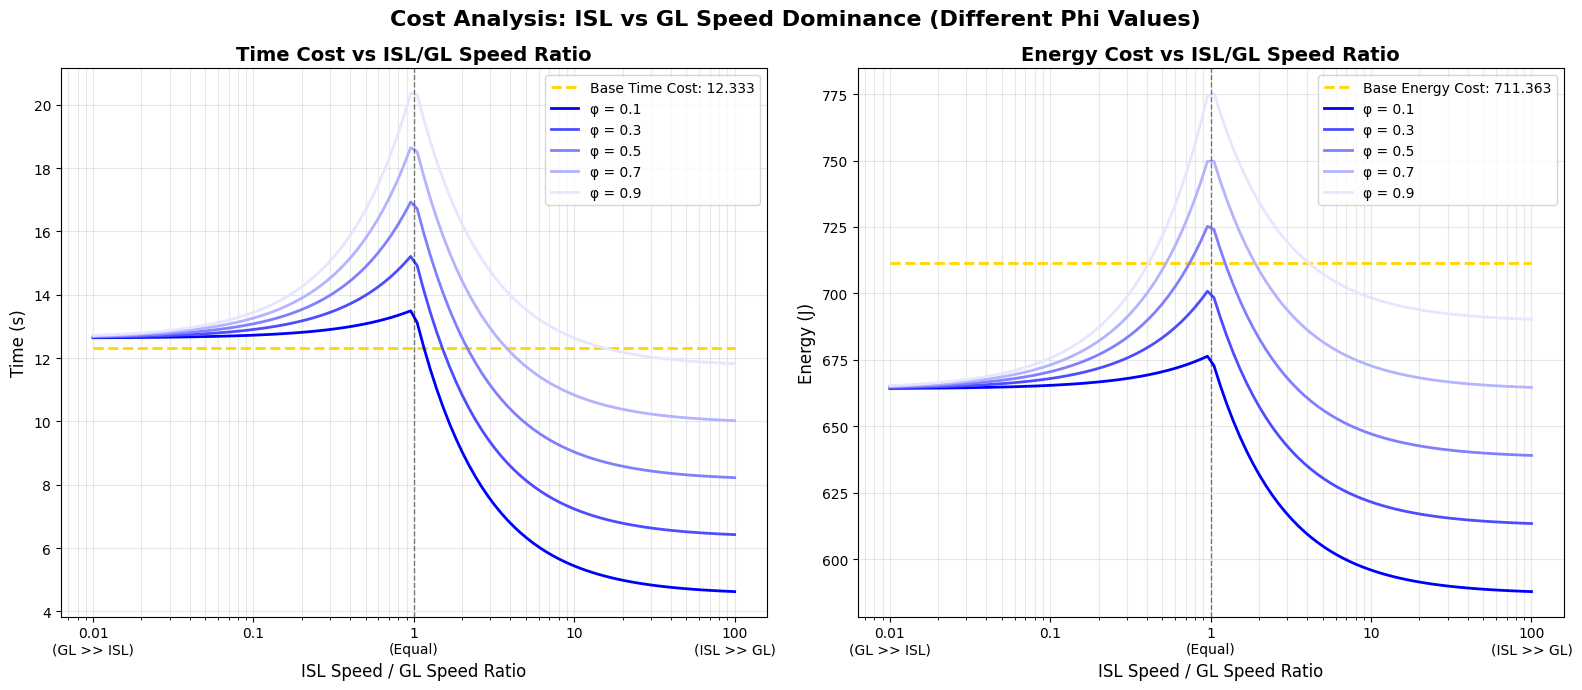

Dual plot saved as PNG: isl_gl_ratio.png


In [6]:
# Display both plots side by side using enhanced DualPlot
log_dual_plot = LogDualPlot(
    left_plotter=time_plotter,
    right_plotter=energy_plotter,
    figsize=(16, 7),
    main_title="Cost Analysis: ISL vs GL Speed Dominance (Different Phi Values)"
)

log_dual_plot.plot()

log_dual_plot.export_png('isl_gl_ratio.png', dpi=500)